## All imports 

In [1]:
#General torch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from torch.utils.data import Subset
import torch.nn.functional as F
from torch_geometric.data import Data
from torch.utils.data import random_split

#Imports for GCN model aspects
from torch_geometric.nn import GCNConv
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.neighbors import NearestNeighbors


#Random/Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
#Root directory
data_dir = 'EUROSAT_RGB/EuroSAT_RGB'

## Loading in Dataset with Transformations

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define transformations
transform = transforms.Compose([
    #Size of the images after they are coming into the model.  Reduced size, which leads to fster run times but could be sacrificing some accuracy.  Could
    #possibly be a plus side as due to the reduction in the data granularity might prevent overfitting.
    transforms.Resize((64, 64)),
    #Flipping for data augmentation to add robustness to dataset
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #Makes it a tensor for use in the resnet model
    transforms.ToTensor(),
    #Standardizing to these values as this is what the imagenet dataset was trained on, so that the data will work more smoothly with the model
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Loading the dataset from the root directory and applying the transform on it
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

#Print class names to verify they loaded in correctly
print("Classes:", dataset.classes)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [5]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: EUROSAT_RGB/EuroSAT_RGB
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## Displaying Images

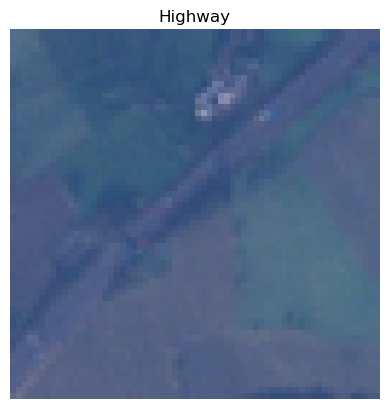

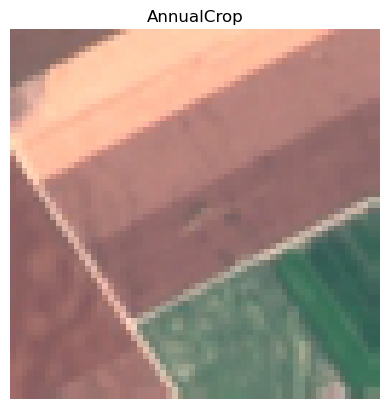

In [7]:
image, label = dataset[10000] 

#Short function that can create an image of a given image at a given index
def create_image(img):
    #Changes the image into the correct order.  Was color, height, width. Became height, width, color.  
    img = img.permute(1, 2, 0)
    #Reverses the normalization of the image (would be very blue otherwise)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  #Ensure valid range
    #Grabs the title of the label from the dataset class list
    plt.title(dataset.classes[label])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

image, label = dataset[10000] 
create_image(image)
image, label = dataset[100] 
create_image(image)

## Helper Functions for GCN Implementation

In [9]:
class CNN_GCN_Hybrid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        #Load pretrained ResNet18 without final classifier
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  #outputs [B, 512, 1, 1]

        #GCN layers
        self.gcn1 = GCNConv(512, 256)
        #self.gcn2 = GCNConv(256, num_classes)
        self.gcn2 = GCNConv(256, 128)
        self.gcn3 = GCNConv(128, num_classes)

    def forward(self, images, edge_index):
        batch_size = images.size(0)

        #Extract features using ResNet
        feats = self.feature_extractor(images).view(batch_size, -1)

        #GCN on graph
        x = F.relu(self.gcn1(feats, edge_index))
        x = self.gcn2(x, edge_index)

        return x

In [10]:
#pulls features from the model for the whole dataset (like resnet w/o classifier)
def extract_features_for_dataset(model, dataloader, device):
    model.eval()
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            #move images to GPU
            imgs = imgs.to(device) 
            #forward pass (model should return feature vecs)
            feats = model(imgs)    
            #bring back to CPU so we can store
            all_feats.append(feats.cpu()) 
            #labels are already on CPU
            all_labels.append(lbls)        

    #put everything together
    #shape should be [total_samples, 512]
    all_feats = torch.cat(all_feats, dim=0)  
    all_labels = torch.cat(all_labels, dim=0)
    return all_feats, all_labels

In [11]:
#builds a knn graph from feature vectors using cosine similarity
def build_knn_graph(features, k=5):
    #move to numpy so sklearn can work with it
    feats_np = features.detach().cpu().numpy()

    #use sklearn to do knn (cosine similarity makes more sense here for features)
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(feats_np)
    #returns sparse matrix
    adj = knn.kneighbors_graph(feats_np)
    #needed to get row/col format
    adj = adj.tocoo()

    #get edge index from sparse matrix
    rows = adj.row
    cols = adj.col
    #stack rows and cols into shape [2, num_edges]
    indices = np.vstack([rows, cols])  

    #turn into torch tensor so we can use it in GCN
    edge_index = torch.tensor(indices, dtype=torch.long)
    
    return edge_index

## Created the Dataloaders for Training

In [13]:
#Grab the length of the data set and the indices of the data set
dataset_size = len(dataset)
indices = list(range(dataset_size))

#train test split does not have a validation set option, so first split into train indices and non-train indices
train_indices, non_train_indices = train_test_split(indices, test_size=0.3, random_state=0)

#This train test split is the remaining 30% of the data, so keeping about two thirds of the data for testing and one third for validation results
#in a train val test split of 0.7, 0.1, and 0.2 respectively, which is appears to be a fairly standard split for training using CNN's
val_indices, test_indices = train_test_split(non_train_indices, test_size=0.6666666, random_state=0)

#Create new data sets using the indices created by train test split
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

#Created a dataloader for this train/val/split using the new data sets that were created.  Shuffled the train loader as the order of the data could be
#Important during the training, as you do not want a batch that is predominantly all one class, thus the trainloader should be shuffled.  Batch size
#is 64 as this will being a good balance of training speed without a strong propensity for overfitting.  
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Node Classification Prep

In [15]:
class_num = len(dataset.classes)

model = CNN_GCN_Hybrid(num_classes=class_num).to(device)
#Modify the last layer to match the number of classes, as the pretrained model has 1000 classes, which must be changed to the number of classes we actually have


#Loss function is cross entropy, as this is typically seen as a good choice for multiclass datasets
crit = nn.CrossEntropyLoss()
#Using an weighted adam optimizer, which can lead to quick convergence and better weight decay, which makes the model more generalizable
#realized that I was using no weight decay initially as I thought it was automatically set to 0.0001, used it and it might be sub optimal
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay = 0.0001)



#Using 20 epochs, as this is the number that got me this highest accuracy for this model
num_epochs = 20
tr_losses, val_losses = [], []
#Begin training model here:

#Feature extractor only (no final FC)
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

#Use a DataLoader over the entire dataset
full_loader = DataLoader(dataset, batch_size=64, shuffle=False)
all_features, all_labels = extract_features_for_dataset(feature_extractor, full_loader, device)




#build a knn graph from the features
edge_index = build_knn_graph(all_features, k=5)

#wrap everything into a PyTorch Geometric Data object
graph_data = Data(x=all_features, y=all_labels, edge_index=edge_index)

#figure out how many nodes total and how much to use for train/val/test
num_nodes = graph_data.num_nodes
train_len = int(0.7 * num_nodes)
val_len = int(0.1 * num_nodes)
test_len = num_nodes - train_len - val_len  #whatever's left

#randomly split indices into train, val, test
train_idx, val_idx, test_idx = random_split(torch.arange(num_nodes), [train_len, val_len, test_len])

#create masks for training, validation, and testing
graph_data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

#apply the masks to the proper indices
graph_data.train_mask[train_idx.indices] = True
graph_data.val_mask[val_idx.indices] = True
graph_data.test_mask[test_idx.indices] = True

C:\Users\ryanj\anaconda3\envs\pytorch_cuda12\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryanj\anaconda3\envs\pytorch_cuda12\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training and Validation

Val Loss: 0.6596 | Val Accuracy: 82.33
Val Loss: 0.5294 | Val Accuracy: 86.26
Val Loss: 0.4604 | Val Accuracy: 88.48
Val Loss: 0.5399 | Val Accuracy: 87.04
Val Loss: 0.6215 | Val Accuracy: 81.81
Val Loss: 0.4278 | Val Accuracy: 89.37
Val Loss: 0.8839 | Val Accuracy: 78.44
Val Loss: 0.4464 | Val Accuracy: 89.48
Val Loss: 0.4040 | Val Accuracy: 89.89
Val Loss: 0.3791 | Val Accuracy: 90.19
Val Loss: 0.4460 | Val Accuracy: 89.22
Val Loss: 0.3775 | Val Accuracy: 90.59
Val Loss: 0.4031 | Val Accuracy: 89.33
Val Loss: 0.4399 | Val Accuracy: 88.89
Val Loss: 0.4295 | Val Accuracy: 89.00
Val Loss: 0.4424 | Val Accuracy: 88.56
Val Loss: 0.3480 | Val Accuracy: 91.63
Val Loss: 0.7137 | Val Accuracy: 80.52
Val Loss: 0.4589 | Val Accuracy: 88.48
Val Loss: 0.3380 | Val Accuracy: 91.48


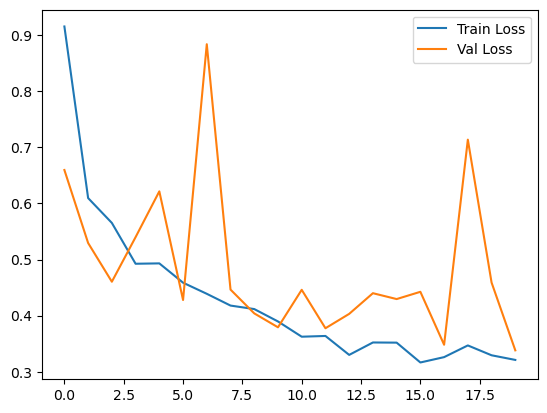

In [17]:
for epoch in range(num_epochs):
    #Put the model in training mode
    model.train()
    #Start counting the total loss
    loss_total = 0.0
    #This for goes through each of the images and corresponding labels in a batch in the train_dataloader, and then applies the model to it
    model.train()
    loss_total = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
    
        #Extract features to build graph so can be used in GCN
        with torch.no_grad():
            feats = model.feature_extractor(images).view(images.size(0), -1)
    
        #Build knn graph
        edge_index = build_knn_graph(feats, k=5).to(device)
    
        #Forward pass
        outputs = model(images, edge_index)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()
    
        loss_total += loss.item()
    #Calculate the average loss over the entire epoch
    avg_tr_loss = loss_total / len(trainloader)
    #Adds the train losses to the list for plotting
    tr_losses.append(avg_tr_loss)

    #Puts model in evaluation mode and resets variables for evaluation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
    
            #Extract batch features for graph
            feats = model.feature_extractor(images).view(images.size(0), -1)
    
            #Build knn graph for this batch
            edge_index = build_knn_graph(feats, k=5).to(device)
    
            #Run through the model
            outputs = model(images, edge_index)
    
            #Compute loss and accuracy
            loss = crit(outputs, labels)
            val_loss += loss.item()
    
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = 100. * correct / total
    val_losses.append(avg_val_loss)
    
    print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}")

#Plot training and validation loss
plt.plot(range(num_epochs), tr_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.legend()
plt.show()

## Testing and Plotting

Test Loss: 0.3250 | Test Accuracy: 91.13


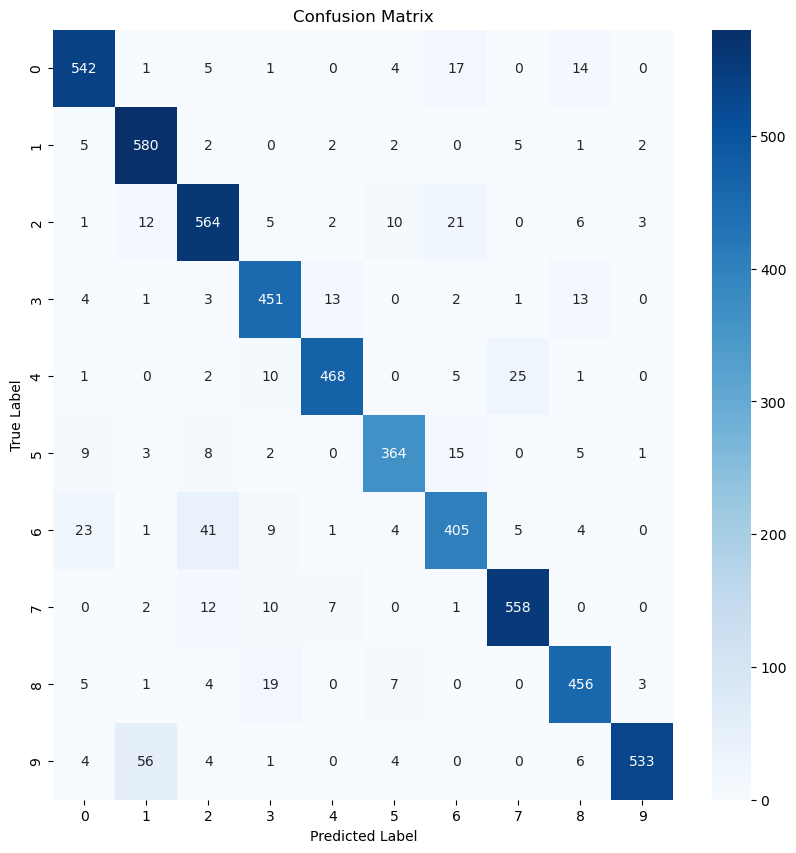

Test Loss:  0.32498436386094376
Test Accuracy:  91.12962962962963
Test Precision:  0.9126570617405563
Test recall:  0.9112962962962963
Test f1:  0.9112251986135149


In [19]:
#Set the mode to evaluation for the final testing of the data on test data
model.eval()
test_loss = 0.0
correct = 0
total = 0
preds = []
test_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        #Extract features for graph
        feats = model.feature_extractor(images).view(images.size(0), -1)

        #Build knn graph for this batch
        edge_index = build_knn_graph(feats, k=5).to(device)

        #Forward pass
        outputs = model(images, edge_index)

        #Compute loss and accuracy
        loss = crit(outputs, labels)
        test_loss += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())



#Average test loss and accuracy
avg_test_loss = test_loss / len(testloader)
test_accuracy = 100. * correct / total
#Other metrics for the requirements
precision = precision_score(test_labels, preds, average='weighted')
recall = recall_score(test_labels, preds, average='weighted')
f1 = f1_score(test_labels, preds, average='weighted')

#Print results
print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}")

#Confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(class_num), yticklabels=range(class_num))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#Gets the average_test_loss
avg_test_loss = test_loss / len(testloader)
#Gets the test accuracy
test_accuracy = 100 * correct / total
#Prints the final results of the model
print("Test Loss: ", avg_test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", precision)
print("Test recall: ", recall)
print("Test f1: ", f1)